CLUSTERING

In [1]:
import pandas as pd
import numpy as np

ruta_archivo = r"C:\Users\etorres.DERCOPARTS\DERCO CHILE REPUESTOS SpA\Planificación y abastecimiento - Documentos\Planificación y Compras AFM\S&OP Demanda\Codigos Demanda\Scripts\Ciclo\SI_SO Ciclo Sep-2024AE.csv"
df = pd.read_csv(ruta_archivo, delimiter=',', decimal=',', encoding='utf-8').rename(columns={'Canal': 'Canal 3', 'Cantidad': 'Venta', 'idSKU': 'Ultimo Eslabón'})
df['ID'] = df['Ultimo Eslabón'].astype(str) + df['Canal 3'].astype(str)
df['Fecha'] = pd.to_datetime(df['Fecha'], format='%Y-%m-%d')
df = df.sort_values(by=['Ultimo Eslabón', 'Fecha']).reset_index(drop=True)
pivot_table = df.pivot_table(index=['Ultimo Eslabón', 'Canal 3'], columns='Fecha', values='Venta', fill_value=0).reset_index()
pivot_table = pivot_table[pivot_table.iloc[:, 2:].sum(axis=1) != 0]
ultima_fecha = pivot_table.columns[-1]
primer_fecha = ultima_fecha - pd.DateOffset(months=23)
ventas_ultimos_24_meses = pivot_table.loc[:, primer_fecha:ultima_fecha]
intervalos = ventas_ultimos_24_meses.apply(lambda x: (x != 0).astype(int).diff().fillna(1).abs().sum(), axis=1)
ventas_activas = (ventas_ultimos_24_meses != 0).sum(axis=1)
pivot_table['ADI'] = intervalos / ventas_activas
ventas_no_cero = ventas_ultimos_24_meses.replace(0, np.nan)
pivot_table['CV²'] = (ventas_no_cero.std(axis=1) / ventas_no_cero.mean(axis=1)) ** 2
def clasificar_demanda(row):
    if row['ADI'] < 1.32 and row['CV²'] < 0.49: return 'Smooth'
    elif row['ADI'] >= 1.32 and row['CV²'] < 0.49: return 'Intermittent'
    elif row['ADI'] < 1.32 and row['CV²'] >= 0.49: return 'Erratic'
    else: return 'Lumpy'
pivot_table['Cluster'] = pivot_table.apply(clasificar_demanda, axis=1)
melted_data = pivot_table.melt(id_vars=['Ultimo Eslabón', 'Canal 3', 'ADI', 'CV²', 'Cluster'], var_name='Fecha', value_name='Venta')
melted_data['Fecha'] = pd.to_datetime(melted_data['Fecha'], format='%Y-%m-%d')
data = melted_data
data.shape

(4701527, 7)

In [4]:
# Filtrar los ID únicos con su Demand Type (Cluster)
id_unicos_con_cluster = pivot_table[['Ultimo Eslabón', 'Canal 3', 'Cluster']].drop_duplicates()

# Ruta donde deseas guardar el archivo Excel
ruta_exportacion = r"C:\Users\etorres.DERCOPARTS\DERCO CHILE REPUESTOS SpA\Planificación y abastecimiento - Documentos\Planificación y Compras AFM\S&OP Demanda\Codigos Demanda\Scripts\Ciclo\ID_Demand_Type.xlsx"

# Exportar el DataFrame a un archivo Excel
id_unicos_con_cluster.to_excel(ruta_exportacion, index=False)

print(f"Archivo exportado correctamente a {ruta_exportacion}")


Archivo exportado correctamente a C:\Users\etorres.DERCOPARTS\DERCO CHILE REPUESTOS SpA\Planificación y abastecimiento - Documentos\Planificación y Compras AFM\S&OP Demanda\Codigos Demanda\Scripts\Ciclo\ID_Demand_Type.xlsx


In [2]:
unique_counts = melted_data.groupby('Cluster').apply(lambda x: x[['Ultimo Eslabón', 'Canal 3']].drop_duplicates().shape[0])
filas_count = melted_data['Cluster'].value_counts()
print("Unique counts of ID & Canal 3 per Demand Type:")
print(unique_counts)
print("\nRow counts per Demand Type:")
print(filas_count)

Unique counts of ID & Canal 3 per Demand Type:
Cluster
Erratic          4432
Intermittent     4490
Lumpy           39709
Smooth          10882
dtype: int64

Row counts per Demand Type:
Cluster
Lumpy           3137011
Smooth           859678
Intermittent     354710
Erratic          350128
Name: count, dtype: int64


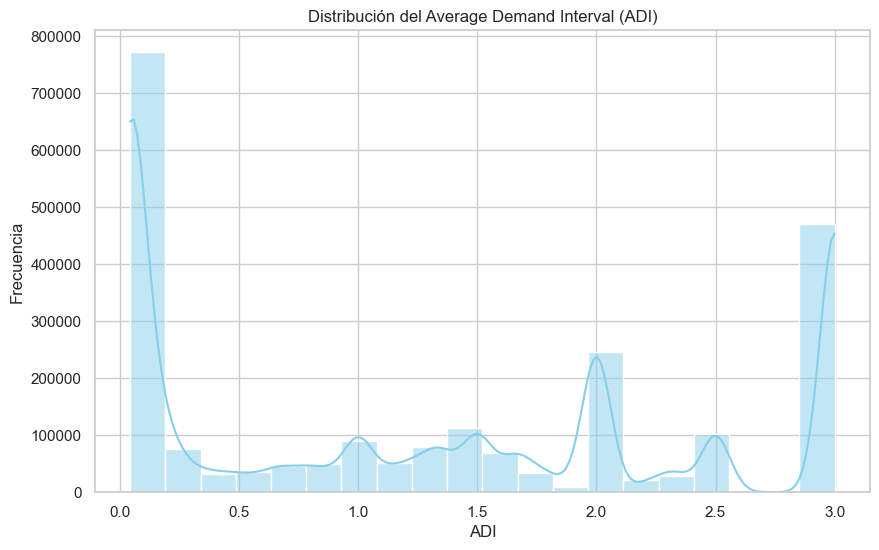

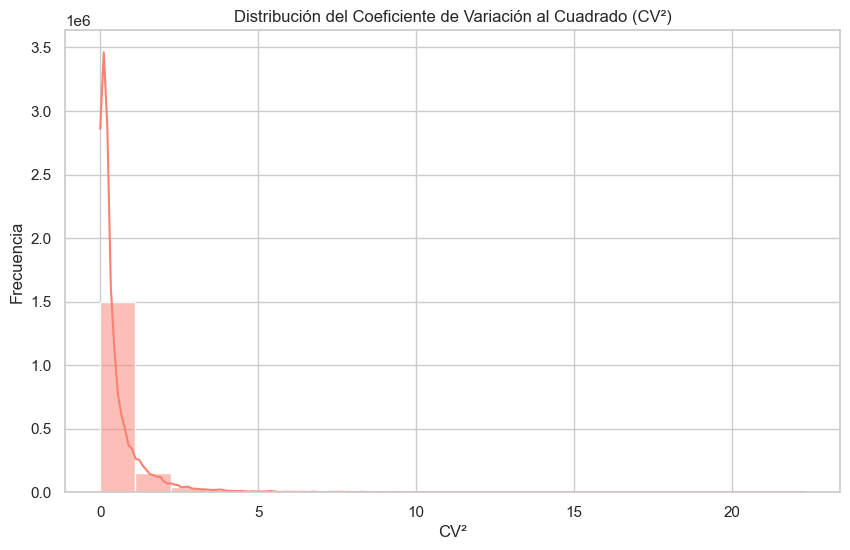

c:\Users\etorres.DERCOPARTS\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


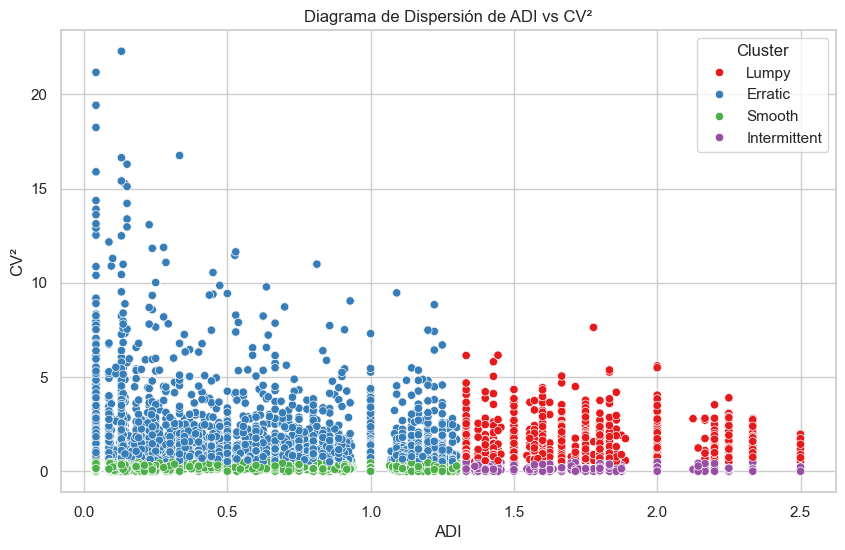

C:\Users\etorres.DERCOPARTS\AppData\Local\Temp\ipykernel_7916\2930704772.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Cluster', data=clustering_df, palette='Set2')


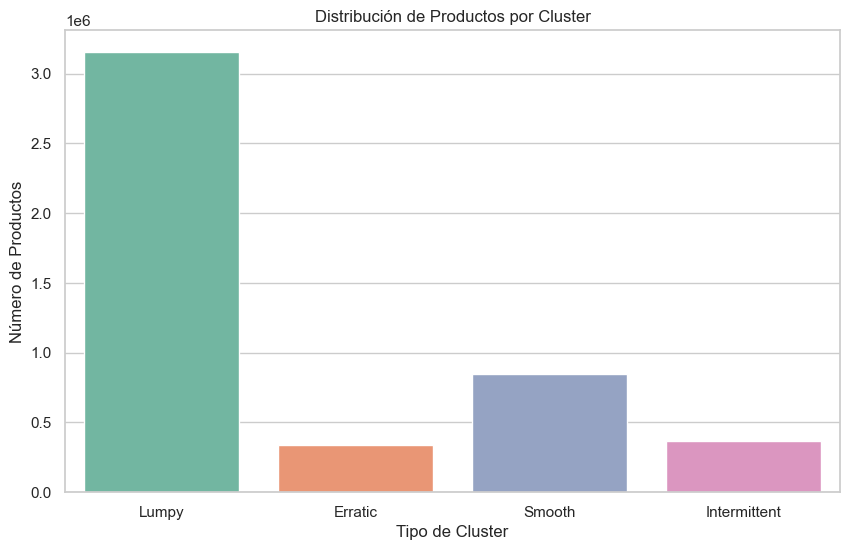

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
clustering_df = data
# Configuración de estilo para los gráficos
sns.set(style="whitegrid")

# Histograma del ADI
plt.figure(figsize=(10, 6))
sns.histplot(clustering_df['ADI'].dropna(), kde=True, color="skyblue", bins=20)
plt.title('Distribución del Average Demand Interval (ADI)')
plt.xlabel('ADI')
plt.ylabel('Frecuencia')
# plt.savefig(os.path.join(output_dir, 'histograma_adi.png'))
plt.show()

# Histograma del CV²
plt.figure(figsize=(10, 6))
sns.histplot(clustering_df['CV²'].dropna(), kde=True, color="salmon", bins=20)
plt.title('Distribución del Coeficiente de Variación al Cuadrado (CV²)')
plt.xlabel('CV²')
plt.ylabel('Frecuencia')
# plt.savefig(os.path.join(output_dir, 'histograma_cv2.png'))
plt.show()

# Diagrama de dispersión de ADI vs CV²
plt.figure(figsize=(10, 6))
sns.scatterplot(x='ADI', y='CV²', hue='Cluster', data=clustering_df, palette='Set1')
plt.title('Diagrama de Dispersión de ADI vs CV²')
plt.xlabel('ADI')
plt.ylabel('CV²')
plt.legend(title='Cluster')
# plt.savefig(os.path.join(output_dir, 'dispersión_adi_cv2.png'))
plt.show()

# Contador de los diferentes clusters
plt.figure(figsize=(10, 6))
sns.countplot(x='Cluster', data=clustering_df, palette='Set2')
plt.title('Distribución de Productos por Cluster')
plt.xlabel('Tipo de Cluster')
plt.ylabel('Número de Productos')
# plt.savefig(os.path.join(output_dir, 'conteo_clusters.png'))
plt.show()


In [8]:
print("\nGenerando gráficos estadísticos para visualizar el clustering...\n")

print("1. Histograma del ADI:")
print("   Este gráfico muestra la distribución del Average Demand Interval (ADI).")
print("   Un ADI bajo indica que las demandas ocurren en intervalos regulares.")
print("   Un ADI alto sugiere que la demanda es más intermitente.\n")

print("2. Histograma del CV²:")
print("   Este gráfico muestra la variabilidad en las cantidades vendidas, medida por el Coeficiente de Variación al Cuadrado (CV²).")
print("   Un CV² bajo indica consistencia en las cantidades vendidas, mientras que un CV² alto indica alta variabilidad.\n")

print("3. Diagrama de dispersión de ADI vs CV²:")
print("   Este gráfico es crucial para identificar visualmente cómo se clasifican los productos.")
print("   Cada punto representa un producto, y los colores indican a qué cluster pertenece.")
print("   Es útil para ver la relación entre la regularidad de la demanda y la variabilidad en las cantidades.\n")

print("4. Conteo de productos por Cluster:")
print("   Este gráfico de barras muestra cuántos productos pertenecen a cada cluster.")
print("   Es útil para entender la distribución general y cuántos productos tienen patrones de demanda difíciles de predecir.\n")

print("Los gráficos se han guardado en el directorio especificado. Puedes incluirlos en tu PPT para respaldar tus hallazgos con visuales claros y explicativos.\n")



Generando gráficos estadísticos para visualizar el clustering...

1. Histograma del ADI:
   Este gráfico muestra la distribución del Average Demand Interval (ADI).
   Un ADI bajo indica que las demandas ocurren en intervalos regulares.
   Un ADI alto sugiere que la demanda es más intermitente.

2. Histograma del CV²:
   Este gráfico muestra la variabilidad en las cantidades vendidas, medida por el Coeficiente de Variación al Cuadrado (CV²).
   Un CV² bajo indica consistencia en las cantidades vendidas, mientras que un CV² alto indica alta variabilidad.

3. Diagrama de dispersión de ADI vs CV²:
   Este gráfico es crucial para identificar visualmente cómo se clasifican los productos.
   Cada punto representa un producto, y los colores indican a qué cluster pertenece.
   Es útil para ver la relación entre la regularidad de la demanda y la variabilidad en las cantidades.

4. Conteo de productos por Cluster:
   Este gráfico de barras muestra cuántos productos pertenecen a cada cluster.
   